In [1]:
#-*- coding : utf-8 -*-
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from stMMR.utils import *
from stMMR.process import *
from stMMR import train_model
from datetime import datetime

In [2]:
section_id = 7
k=7

In [3]:
im_re = pd.read_csv("../Data/chicken_heart/D{}/ViT_pca_representation.csv".format(section_id),
                    header=0, index_col=0, sep=',')
print(section_id, k)
adata = sc.read_10x_h5("../Data/chicken_heart/D{}"
    "/chicken_heart_spatial_RNAseq_D{}_filtered_feature_bc_matrix.h5".format(section_id,section_id))
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
# prefilter_specialgenes(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
adata.obsm["im_re"] = im_re


coor_df = pd.read_csv(os.path.join('../Data/chicken_heart/D{}'
    '/chicken_heart_spatial_RNAseq_D{}_tissue_positions_list.csv'.format(section_id,section_id),
         ), sep=",",header=None,na_filter=False, index_col=0)
# adata.obs["y_pixel"] = coor_df[4]
# adata.obs["x_pixel"] = coor_df[5]
adata.obs["array_row"] = coor_df[4]*-1
adata.obs["array_col"] = coor_df[5]
adata.obsm["spatial"] = coor_df.loc[adata.obs_names, [4,5]].to_numpy()

Ann_df = pd.read_csv("../Data/chicken_heart/D{}/D{}.csv".format(section_id,section_id), sep=",", header=0,
                      na_filter=False, index_col=0)
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, "region"]
adata.obs['ground_truth'] = adata.obs['Ground Truth']

7 7


In [4]:
adata.obsm["adj"] = calculate_adj_matrix(adata)
adata= train_model.train(adata,k,n_epochs=200,h=[3000,3000],lr=0.00001)

[2024-10-01 00:27:05] Epoch: 0/200, Loss: 14.3508
[2024-10-01 00:27:15] Epoch: 5/200, Loss: 14.0785
[2024-10-01 00:27:27] Epoch: 10/200, Loss: 13.8183
[2024-10-01 00:27:37] Epoch: 15/200, Loss: 13.5635
[2024-10-01 00:27:47] Epoch: 20/200, Loss: 13.3126
[2024-10-01 00:27:57] Epoch: 25/200, Loss: 13.0549
[2024-10-01 00:28:07] Epoch: 30/200, Loss: 12.7399
[2024-10-01 00:28:16] Epoch: 35/200, Loss: 11.9038
[2024-10-01 00:28:27] Epoch: 40/200, Loss: 10.0811
[2024-10-01 00:28:36] Epoch: 45/200, Loss: 9.6879
[2024-10-01 00:28:46] Epoch: 50/200, Loss: 9.5265
[2024-10-01 00:28:56] Epoch: 55/200, Loss: 9.1775
[2024-10-01 00:29:06] Epoch: 60/200, Loss: 8.9849
[2024-10-01 00:29:16] Epoch: 65/200, Loss: 8.8124
[2024-10-01 00:29:24] Epoch: 70/200, Loss: 8.6119
[2024-10-01 00:29:34] Epoch: 75/200, Loss: 8.4574
[2024-10-01 00:29:42] Epoch: 80/200, Loss: 8.3090
[2024-10-01 00:29:52] Epoch: 85/200, Loss: 8.1629
[2024-10-01 00:30:01] Epoch: 90/200, Loss: 8.0312
[2024-10-01 00:30:10] Epoch: 95/200, Loss: 

Adjusted rand index = 0.41826


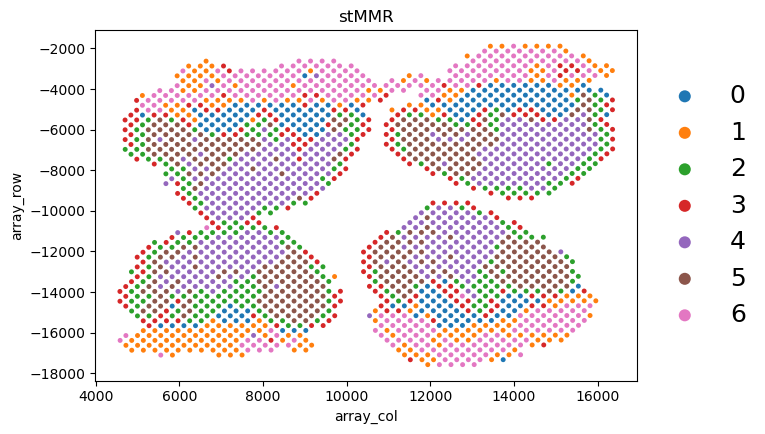

In [5]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['stMMR'], obs_df['Ground Truth'])
print('Adjusted rand index = %.5f' % ARI)
sc.pl.scatter(adata, x="array_col", y="array_row", color='stMMR', legend_fontsize=18, show=True,
                   size=100000 / adata.shape[0])

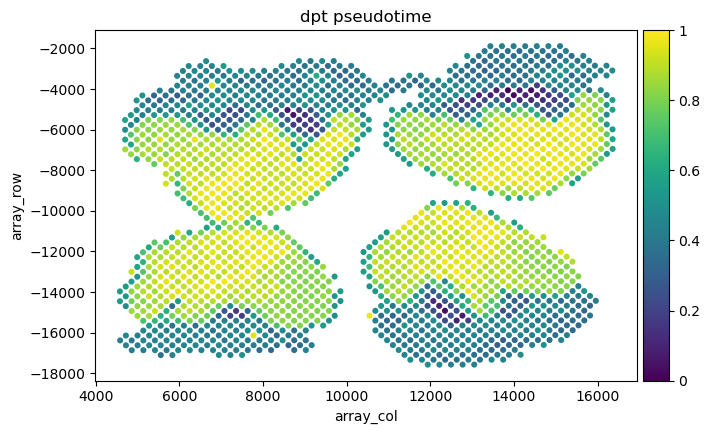

In [6]:
sc.pp.neighbors(adata, use_rep='emb_pca')
adata.uns['iroot'] = np.flatnonzero(adata.obs['stMMR'] =="4")[0]  #D7

sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings=1)
adata.obs['dpt_pseudotime'] =1-adata.obs['dpt_pseudotime']
sc.pl.scatter(adata, x="array_col", y="array_row", color='dpt_pseudotime', legend_fontsize=18, show=True,
                   size=150000 / adata.shape[0])
